In [1]:
"""
Abraham Tishelman-Charny 
22 September 2021 

The purpose of this notebook is to compare flashgg and NanoAOD framework outputs of the 
same process. As a first example, a comparison of SM HH->WWgg->qqlnugg with 2017 
detector reconstruction. The purpose being to show a NanoAOD framework produces 
the same results as flashgg. 

MiniAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17MiniAODv2-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/MINIAODSIM
NanoAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM

"""

'\nAbraham Tishelman-Charny \n22 September 2021 \n\nThe purpose of this notebook is to compare flashgg and NanoAOD framework outputs of the \nsame process. As a first example, a comparison of SM HH->WWgg->qqlnugg with 2017 \ndetector reconstruction. The purpose being to show a NanoAOD framework produces \nthe same results as flashgg. \n\nMiniAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17MiniAODv2-PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/MINIAODSIM\nNanoAOD: /GluGluToHHTo2G2Qlnu_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM\n\n'

In [2]:
import uproot 
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd 

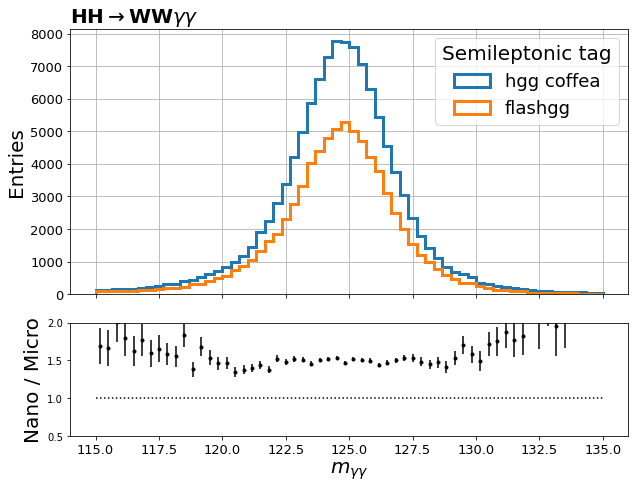

In [21]:
%matplotlib inline

xmin, xmax, xbins = 115, 135, 60
bins = np.linspace(xmin, xmax, xbins + 1)
binWidth = (xmax - xmin) / xbins

X = pd.read_parquet("../HHWWgg_SL/")
categories = X['best_tag']%40

# num vals: len(X['mass'][categories == 0])

flashgg_ntuple = uproot.open("GluGluToHHTo2G2Qlnu_node_cHHH1_2017.root")
flashgg_SL_tree = flashgg_ntuple["tagsDumper/trees"]["GluGluToHHTo2G2Qlnu_node_cHHH1_13TeV_HHWWggTag_0"]
flashgg_SL_mass = flashgg_SL_tree["CMS_hgg_mass"].array()

hggcoffea_vals = X['mass'][categories == 0]
flashgg_vals = flashgg_SL_mass

hggcoffea_binVals, hggcoffea_edges, _ = plt.hist(hggcoffea_vals, bins = bins) 
plt.close() # to avoid showing intermediate histogram
flashgg_binVals, flashgg_edges, _ = plt.hist(flashgg_vals, bins = bins) 
plt.close() # to avoid showing intermediate histogram 

##-- Create plot 
fig, axarr = plt.subplots(2, 
                            sharex=True, 
                            gridspec_kw={
                                'hspace': 0.15,
                                'height_ratios': (0.7,0.3)
                                }
                            )    
fig.set_size_inches(10, 7.5)
upper = axarr[0]
lower = axarr[1]  

ratio = np.true_divide(hggcoffea_binVals, flashgg_binVals, out = np.zeros_like(flashgg_binVals), where = flashgg_binVals != 0)

binCenters = [float(a) + (float(binWidth)/2.) for a in hggcoffea_edges[:-1]] # use hggcoffea_edges since they should all be the same anyway 
zero_errors = [0 for entry in binCenters]

upper.hist(X['mass'][categories == 0], bins = bins, histtype = 'step', linewidth = 3, label = "hgg coffea")
upper.hist(flashgg_SL_mass, bins = bins, histtype = 'step', linewidth = 3, label = "flashgg")

# Ratio 
lower.tick_params(axis = 'x', labelsize = 13)
upper.tick_params(axis = 'y', labelsize = 13)
upper.set_ylabel("Entries", fontsize = 20)
upper.ticklabel_format(style='plain') ##-- Remove scientific notation
lower.set_xlabel(r"$m_{\gamma\gamma}$", fontsize = 20)
lower.set_ylabel("Nano / Micro", fontsize = 20)
lower.set_ylim(0.5, 2)
lower.plot([xmin, xmax],[1,1],linestyle=':', color = 'black')

# Stat errors 
errors = []
for val_i, hggcoffea_val in enumerate(hggcoffea_binVals):
    flashgg_val = flashgg_binVals[val_i]
    r_val = ratio[val_i]
    if(flashgg_val <= 0): 
        errors.append(0.)
    else:
        rel_err = np.sqrt( (1 / hggcoffea_val) + (1 / flashgg_val) ) # statistical uncertainty assuming event weights of 1 
        err = float(rel_err) * r_val
#         MC_stack_w2 = binned_MC_stat_uncertainties[val_i]
#         rel_err = np.sqrt( (1 / d_val) + (MC_stack_w2 / MC_Stack_val)**2 ) sqrt(sum(w^2)) per bin for MC stack uncertainty 
        errors.append(err)

lower.errorbar(binCenters, ratio, xerr = zero_errors , yerr = errors, marker = '.', color = 'black', ls = '')  

# Decorate 
# upper.set_title("Hgg coffea, flashgg comparison", fontsize = 20) 
upper.text(
    # 0.05, 0.9, u"CMS $\it{Preliminary}$",
    0., 1., r"HH$\rightarrow$WW$\gamma\gamma$",
    fontsize=20, fontweight='bold',
    horizontalalignment='left',
    verticalalignment='bottom',
    transform=upper.transAxes
)

upper.legend(loc = 'best', fontsize = 18, title = "Semileptonic tag", title_fontsize = 20)
upper.grid()
plt.show()
plt.close()
